In this notebook, we will try the process of implementing CNN with Keras in order to classify images.

I.   **Firstly**, we'll import useful packages.

II.   **Then**, we'll load the data, before visualize and preprocess it.

III.  **We'll try a simple CNN model** and then we will evaluate its performances.

IV.   **Finally,** we'll use techniques such as data augmentation, learning rate decay and dropout to increase our test F1.

# I. Let import all useful packages.

In [ ]:
from tensorflow import keras
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard
import tensorflow_addons as tfa
import os
import random
import datetime
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import load_img, img_to_array

**Task 1:** Setting Fre GPU in this Google Colab notebook.

[*Hint.*](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d)

## Mounting Google Drive locally
**Task 2:** Mount the Google Driver into the Google Colab Driver.

[*Hint.*](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=eikfzi8ZT_rW)

In [ ]:
## TYPE YOUR CODE for task 2 here:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Task 3**: Copy the zip dataset from Google Drive into Colab, then unzip it and finally remove the zip file to free up space.

[*Hint.*](https://medium.com/datadriveninvestor/speed-up-your-image-training-on-google-colab-dc95ea1491cf)

In [2]:
!unzip -o gdrive/MyDrive/Colab\ Notebooks/data/image-classification.zip -d image-classification

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: image-classification/seg_train/mountain/7539.jpg  
  inflating: image-classification/seg_train/mountain/7551.jpg  
  inflating: image-classification/seg_train/mountain/7560.jpg  
  inflating: image-classification/seg_train/mountain/7565.jpg  
  inflating: image-classification/seg_train/mountain/7578.jpg  
  inflating: image-classification/seg_train/mountain/7581.jpg  
  inflating: image-classification/seg_train/mountain/7586.jpg  
  inflating: image-classification/seg_train/mountain/7647.jpg  
  inflating: image-classification/seg_train/mountain/7652.jpg  
  inflating: image-classification/seg_train/mountain/7654.jpg  
  inflating: image-classification/seg_train/mountain/7662.jpg  
  inflating: image-classification/seg_train/mountain/767.jpg  
  inflating: image-classification/seg_train/mountain/7672.jpg  
  inflating: image-classification/seg_train/mountain/7679.jpg  
  inflating: image-classification/seg_train/moun

In [ ]:
!rm -r gdrive/MyDrive/Colab\ Notebooks/data/image-classification.zip

# II. Load the data.

## About dataset.
This is image data of Natural Scenes around the world.
This Data contains around 25k images of size 150x150 distributed under 6 categories. {'buildings' -> 0, 'forest' -> 1, 'glacier' -> 2, 'mountain' -> 3, 'sea' -> 4, 'street' -> 5 }

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test.


Now, We need to prepare our data to feed into the model. There is a builtin method in Keras that can extract your images from folder.

Following is the gernalized functions used to extract data from the directory.

In [ ]:
# Here's our 6 categories that we have to classify.
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
class_names_label = {'buildings': 0,
                    'forest' : 1,
                    'glacier' : 2,
                    'mountain' : 3,
                    'sea' : 4,
                    'street' : 5
                    }
nb_classes = 6

In [ ]:
def get_key(val):
    for key, value in class_names_label.items():
        if val == float(value):
            return key
    return "Class doesn't exist"

## Loading the Data

**Task 4:** We have to write a load_data function that load the training and test data ( which contain images and the labels) from the folder.

* **Load_data** function return **train_set** and **test_set**. Each set contains **images and labels**.
* Apply 2 augmentation transformations (**shear_range** = 0.2, **zoom_range** = 0.2), shuffle with seed = 8 and rescaling function( to [0, 1]) to **train_set.**
* Apply rescaling funtion to [0, 1]  to **test_set**, no shuffle.
* Batch size = 32.



[*Hint.*](https://keras.io/preprocessing/image/)


In [ ]:
def load_data(data_directories, batch_size, class_mode):
    """
        Load the data:
            - 14,034 images to train the network.
            - 3000 images to evaluate how accurately the network learned to classify images.
        Input:
            Data directory.
        Return: 
            training_set, testing_set.
    """
    ## TYPE YOUR CODE for task 4 here:
    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2)
    test_datagen = ImageDataGenerator(rescale=1./255)

    training_set = train_datagen.flow_from_directory(data_directories[0], classes=class_names,
                                                        class_mode=class_mode,seed=8,target_size=(150,150),batch_size=batch_size)
    testing_set = test_datagen.flow_from_directory(data_directories[1], classes=class_names,
                                                        class_mode=class_mode,seed=8,target_size=(150,150),batch_size=batch_size)
      
    return training_set, testing_set

data_directories = ['image-classification/seg_train/', 'image-classification/seg_test/']
train_dataset_dnn, test_dataset_dnn = load_data(data_directories, 32, 'categorical')
train_dataset_visual, test_dataset_visual = load_data(data_directories, 1, 'sparse')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## Let's explore the dataset.
We can, for example, ask ourselves:

* How many training and testing examples do we have ?
* What is the size of the images ?
* What is the proportion of each observed category ?

As you see, The Training data is in shape of (Number of Training Images, Width of image, Height of image, Channel of image). This shape is very important. If you didnot resize the images to same size. It should be (No. of images,) shape. So, using this shape you cant feed the images to the model.


**Task 5:** Print out:

*  Number of training examples.
*  Number of testing examples.
* Size of each image.



In [ ]:
m_train_samples = len(train_dataset_visual)
m_test_samples = len(test_dataset_visual)
image_size = train_dataset_visual[0][0][0].shape[0]
print(f'Number of training examples: {m_train_samples}')
print(f'Number of testing examples: {m_test_samples}')
print(f'Each image is of size: {(image_size, image_size)}')

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


**Task 6:** Plot a pie chart of the proportion of each class.
You need to show the name and proportion of each class on the pie chart.

*Hint:* [plot.pie](https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html#sphx-glr-gallery-pie-and-polar-charts-pie-features-py)

In [ ]:
X_train = []
y_train = []
for i in range(m_train_samples):
  X_train.append(train_dataset_visual[i][0][0])
  y_train.append(train_dataset_visual[i][1])
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
X_test = []
y_test = []
for i in range(m_test_samples):
  X_test.append(test_dataset_visual[i][0][0])
  y_test.append(test_dataset_visual[i][1])
X_test = np.array(X_test)
y_test = np.array(y_test)

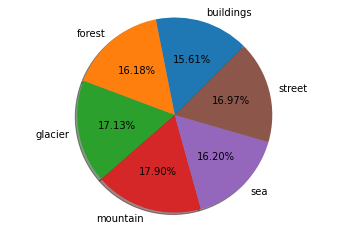

In [ ]:
def plot_pie(train_dataset, class_names):
    ## TYPE YOUR CODE for task 6 here:
    labels = class_names
    sizes = pd.Series(train_dataset.reshape(len(train_dataset))).value_counts().sort_index().values
    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.2f%%', shadow=True, startangle=45)
    ax.axis('equal')
    plt.show()

plot_pie(y_train, class_names)

**Task 7**: Display the 36 random images from the training set.

* Each class contain 6 random images.
* Bellow the image, show the class it belongs to.

*Hint*: [plot.imshow](https://matplotlib.org/3.1.0/gallery/images_contours_and_fields/image_demo.html)

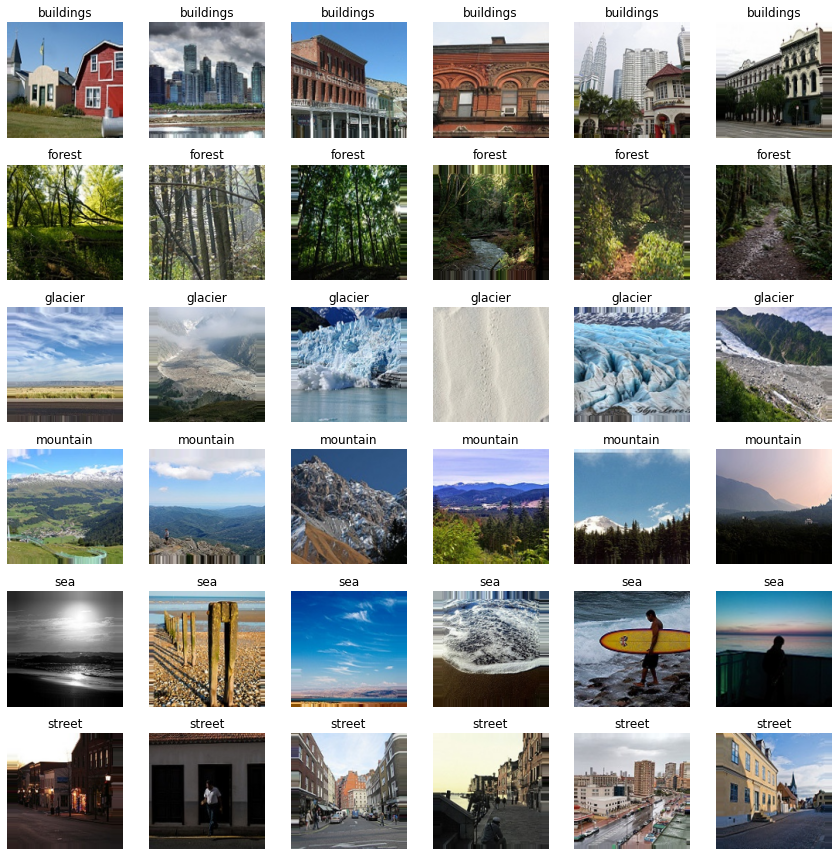

In [ ]:
def visualize_image(train_dataset):
    ## TYPE YOUR CODE for task 7 here:
    total_arr = []
    for lab in range(6):
        idx_arr = []
        for i, val in enumerate(y_train):
            if val == float(lab):
                idx_arr.append(i)
        total_arr.append(idx_arr)
    fig, ax = plt.subplots(6, 6, figsize=(12, 12))
    for i in range(6):
        for j in range(6):
            ax[i][j].set_axis_off()
            ax[i][j].imshow(X_train[total_arr[i][j]])
            ax[i][j].set_title(get_key(y_train[total_arr[i][j]]))
    plt.tight_layout()
    plt.show()

train_dataset = y_train
visualize_image(train_dataset)

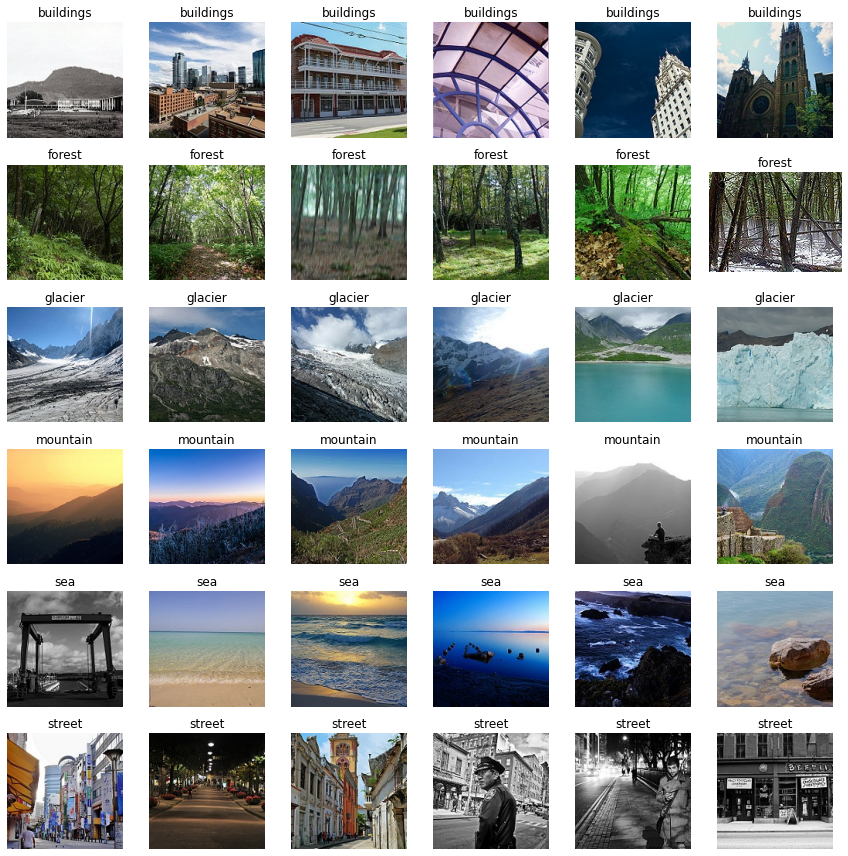

In [ ]:
def visualize_image(train_directory):
    ## TYPE YOUR CODE for task 7 here:
    fig, ax = plt.subplots(6, 6, figsize=(12,12))
    path = train_directory
    subdir_list = os.listdir(path)
    subdir_path_list = [path + '/' + dir for dir in subdir_list]
    for i in range(6):
        subdir_path = subdir_path_list[i]
        image_list = os.listdir(subdir_path)
        for j in range(6):
            im = Image.open(subdir_path + '/' + image_list[j])
            ax[i][j].set_axis_off()
            ax[i][j].imshow(im)
            ax[i][j].set_title(subdir_list[i])
    plt.tight_layout()
    plt.show()

train_directory = 'seg_train/'
visualize_image(train_directory)

# III. Modelling
## There are some steps we need to finish:
* Build the model.

* Compile the model.

* Train / fit the data to the model.

* Evaluate the model on the testing set.


## Build the model
We can build an easy model composed of different layers such as:

* [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D).

* [MaxPooling2D:](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) The images get smaller sized.

* [Flatten:](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) Transforms the format of the images from a 2d-array to a 1d-array of 150 150 3 pixel values.

* [Relu:](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU) given a value x, returns max(x, 0).

* [Softmax:](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Softmax) 6 neurons, probability that the image belongs to one of the classes.

* [Dense.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)

* [Dropout.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)

**Task 8**: Buil a model, which contain these layers:
- Layer 1: Conv2D, 8 filters, kernel_size = (3, 3), activation = 'relu', input_shape = image_shape, same padding.
- Layer 2: Conv2D, 16 filters, kernel_size = (3, 3), activation = 'relu', same padding.
- Layer 3: MaxPooling2D, pooling size = (2, 2).
- Layer 4: Conv2D, 32 filters, kernel_size = (3, 3), activation = 'relu', same padding.
- Layer 5: Conv2D, 64 filters, kernel_size = (3, 3), activation = 'relu', same padding.
- Layer 6: MaxPooling2D, pooling size = (3, 3).
- Layer 7: Conv2D, 128 filters, kernel_size = (3, 3), activation = 'relu', same padding.
- Layer 8: Conv2D, 256 filters, kernel_size = (3, 3), activation = 'relu', same padding.
- Layer 9: MaxPooling2D, pooling size = (5, 5).
- Layer 10: Flatten.
- Layer 11: Dense with number of unit = 100, activation = 'relu'.
- Layer 12: Dropout with probs = 0.5.
- Layer 13: Final dense with number of unit = number of class, activation = 'softmax'.



All the Conv2D and Dense layers are followed by a Batch Norm layer with customized configuration excepts from the last dense layer:

- momentum=0.95 
- epsilon=0.005
- beta_initializer = RandomNormal with mean = 0 and stddev = 0.05
- gammaa_initializer = Constant with value = 0.9


In [ ]:
def create_model():
    '''
    Return: 
        CNN model with 13 layers.
    '''
    
    model = Models.Sequential()
    ## TYPE YOUR CODE for task 8 here:
    model.add(Layers.Conv2D(8, (3,3), input_shape=(150, 150, 3), padding='same'))
    model.add(Layers.BatchNormalization(momentum=0.95, epsilon=0.005, beta_initializer=RandomNormal(mean=0, stddev=0.05)))
    model.add(Layers.Activation('relu'))
    model.add(Layers.Conv2D(16, (3,3), padding='same'))
    model.add(Layers.BatchNormalization(momentum=0.95, epsilon=0.005, beta_initializer=RandomNormal(mean=0, stddev=0.05)))
    model.add(Layers.Activation('relu'))
    model.add(Layers.MaxPooling2D(2,2))
    model.add(Layers.Conv2D(32, (3,3), padding='same'))
    model.add(Layers.BatchNormalization(momentum=0.95, epsilon=0.005, beta_initializer=RandomNormal(mean=0, stddev=0.05)))
    model.add(Layers.Activation('relu'))
    model.add(Layers.Conv2D(64, (3,3), padding='same'))
    model.add(Layers.BatchNormalization(momentum=0.95, epsilon=0.005, beta_initializer=RandomNormal(mean=0, stddev=0.05)))
    model.add(Layers.Activation('relu'))
    model.add(Layers.MaxPooling2D(3,3))
    model.add(Layers.Conv2D(128, (3,3), padding='same'))
    model.add(Layers.BatchNormalization(momentum=0.95, epsilon=0.005, beta_initializer=RandomNormal(mean=0, stddev=0.05)))
    model.add(Layers.Activation('relu'))
    model.add(Layers.Conv2D(256, (3,3), padding='same'))
    model.add(Layers.BatchNormalization(momentum=0.95, epsilon=0.005, beta_initializer=RandomNormal(mean=0, stddev=0.05)))
    model.add(Layers.Activation('relu'))
    model.add(Layers.MaxPooling2D(5,5))
    model.add(Layers.Flatten())
    model.add(Layers.Dense(100))
    model.add(Layers.BatchNormalization(momentum=0.95, epsilon=0.005, beta_initializer=RandomNormal(mean=0, stddev=0.05)))
    model.add(Layers.Activation('relu'))
    model.add(Layers.Dropout(0.5))
    model.add(Layers.Dense(6))
    model.add(Layers.Activation('softmax'))
    return model

model = create_model()

**Task 9:** Compile the model. Then print out the model summary.
* [Compile](https://keras.io/models/model/#compile) the model with Adam Optimizaer, lr = 1e-4, categorical-crossentroy loss and "[F1 score](https://github.com/tensorflow/addons/issues/825)" as metric.
* Print out the model F1.

In [ ]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def optimize(model):
    '''
    Input: 
        Model.
    Return``: 
        Complied model.
    '''
    ## TYPE YOUR CODE for task 9 here:
    model.compile(optimizer=Optimizer.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy',f1])
    
    return model

model = optimize(model)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 8)      32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 150, 150, 8)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 16)      1168      
                                                                 
 batch_normalization_1 (Batc  (None, 150, 150, 16)     64        
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 150, 150, 16)      0

**Task 10**: Setup callback.
* Create the [tensorboard callback](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks) to save the logs.
* Create the [checkpoint callback](https://machinelearningmastery.com/check-point-deep-learning-models-keras/) to save the checkpoint with the best F1 after each epoch. 
* Create the [ReduceLROnPlateau callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau) to reduce learning rate when the validation F1 score has stopped improving with the factor of 0.1 and patience = 2.

In [ ]:
def callback_model(checkpoint_name, logs_name):
    '''
    Input: 
        Best checkpoint name, logs name.
    Return: 
        Callback list, which contains tensorboard callback and checkpoint callback.
    '''
    ## TYPE YOUR CODE for task 10 here:
    callbacks_list = []
    checkpoint = ModelCheckpoint(checkpoint_name, save_weights_only=True, 
                                 save_best_only=True, save_freq='epoch', monitor='val_f1', mode='max')
    reduce_lr = ReduceLROnPlateau(monitor='val_f1', factor=0.1, patience=2, mode='max')
    logdir = os.path.join(logs_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(logdir, histogram_freq=1)
    callbacks_list.append(tensorboard_callback)
    callbacks_list.append(checkpoint)
    callbacks_list.append(reduce_lr)
    return callbacks_list

checkpoint_name = 'gdrive/MyDrive/Colab Notebooks/data/304_asm1_weights.best.hdf5'
logs_name = 'gdrive/MyDrive/Colab Notebooks/data/304_asm1_training_logs'
callbacks_list = callback_model(checkpoint_name, logs_name)

**Task 11:** Train the model.

**Requirement:** 
* Train the model with 10 epochs, generator = train_dataset, validataion_data = test_dataset.
* Return the model with best-checkpoint weights.

*Hint:*
[Fit](https://keras.io/models/sequential/#fit_generator) the model first, then reload the model ([load_model function](https://keras.io/getting-started/faq/)) with best-checkpoint weights.

In [ ]:
def train_model(model, callbacks_list):
    '''
    Input: 
        Model and callback list,
    Return: 
        Model with best-checkpoint weights.
    '''
    ## TYPE YOUR CODE for task 11 here:
    history = model.fit(train_dataset_dnn, validation_data=(test_dataset_dnn), 
                        epochs=10, verbose=1, callbacks=callbacks_list)
    return model, history

model, _ = train_model(model, callbacks_list)

Epoch 1/10
439/439 [==============================] - 1606s 4s/step - loss: 1.1047 - accuracy: 0.5951 - f1: 0.5623 - val_loss: 0.7272 - val_accuracy: 0.7390 - val_f1: 0.7187 - lr: 1.0000e-04
Epoch 2/10
439/439 [==============================] - 1431s 3s/step - loss: 0.7879 - accuracy: 0.7143 - f1: 0.6975 - val_loss: 0.7118 - val_accuracy: 0.7410 - val_f1: 0.7334 - lr: 1.0000e-04
Epoch 3/10
439/439 [==============================] - 1306s 3s/step - loss: 0.6569 - accuracy: 0.7668 - f1: 0.7555 - val_loss: 0.5258 - val_accuracy: 0.8170 - val_f1: 0.8104 - lr: 1.0000e-04
Epoch 4/10
439/439 [==============================] - 1278s 3s/step - loss: 0.5952 - accuracy: 0.7873 - f1: 0.7792 - val_loss: 0.5988 - val_accuracy: 0.7920 - val_f1: 0.7850 - lr: 1.0000e-04
Epoch 5/10
439/439 [==============================] - 1344s 3s/step - loss: 0.5463 - accuracy: 0.8083 - f1: 0.7992 - val_loss: 0.4635 - val_accuracy: 0.8347 - val_f1: 0.8344 - lr: 1.0000e-04
Epoch 6/10
439/439 [=========================

**Task 12**: [Show the tensorboard](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks) in the notebook.

In [ ]:
## TYPE YOUR CODE for task 12 here:
#!kill 685
%load_ext tensorboard 


In [ ]:
%tensorboard --logdir gdrive/MyDrive/Colab\ Notebooks/data/304_asm1_training_logs

**Task 13:** Prediction on test set.
* Complete the get_prediction_classes function.
* Print out the test F1. 

In [ ]:
def get_prediction_classes(model, prediction_dataset):
    ## TYPE YOUR CODE for task 13 here:
    '''
    Input: 
        Model and prediction dataset.
    Return: 
        Prediction list and groundtrurth list with predicted classes.
    '''
    X_test = []
    y_test = []
    for i in range(len(prediction_dataset)):
        for j in range(len(prediction_dataset[i][1])):
            X_test.append(prediction_dataset[i][0][j])
            y_test.append(prediction_dataset[i][1][j])
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_pred = model.predict(X_test)
    return y_pred, y_test

y_pred, y_test = get_prediction_classes(model, test_dataset_dnn)

In [ ]:
print(f1(y_test, y_pred))

tf.Tensor(0.8539633, shape=(), dtype=float32)


**Task 14:** Perform the predicted result on test set using confusion matrix.
Remember to show the class name in the confusion matrix. 

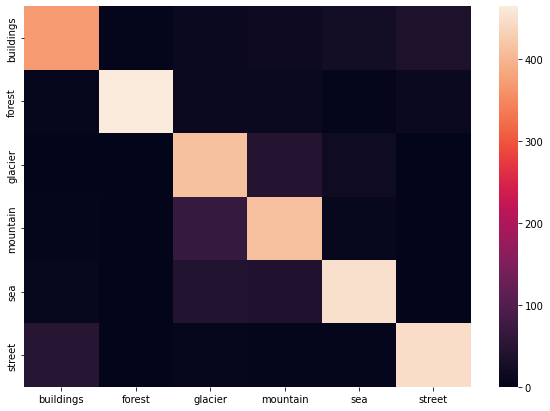

In [ ]:
def plot_confusion_matrix(predictions, groundtruth, class_names):
    ## TYPE YOUR CODE for task 14 here:
    cm = confusion_matrix(predictions, groundtruth)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names)
    plt.show()
plot_confusion_matrix(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1), class_names)

**Task 15**: Model finetuning - fine tune the model using some of these approachs:
* Increase max epochs, change batch size.
* Play around with CNN, Dense and Dropoutlayers (add/# units/etc).
* Increase data augmentation transformations.
* Try to use a [pretrained model](https://www.tensorflow.org/api_docs/python/tf/keras/applications) on Keras.

Requirement: The val_best_F1 should be higher than 87%.

In [ ]:
## TYPE YOUR CODE for task 15 here:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential

In [ ]:
model = ResNet50(include_top=False)

94781440/94765736 [==============================] - 22s 0us/step


In [ ]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
class_names_label = {'buildings': 0,
                    'forest' : 1,
                    'glacier' : 2,
                    'mountain' : 3,
                    'sea' : 4,
                    'street' : 5
                    }
nb_classes = 6

In [ ]:
def load_data(data_directories, batch_size, class_mode):
    """
        Load the data:
            - 14,034 images to train the network.
            - 3000 images to evaluate how accurately the network learned to classify images.
        Input:
            Data directory.
        Return: 
            training_set, testing_set.
    """
    ## TYPE YOUR CODE for task 4 here:
    
    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True,
                                       height_shift_range=0.2)
    test_datagen = ImageDataGenerator(rescale=1./255)

    training_set = train_datagen.flow_from_directory(data_directories[0], classes=class_names,
                                                        class_mode=class_mode,seed=8,target_size=(150,150),batch_size=batch_size)
    testing_set = test_datagen.flow_from_directory(data_directories[1], classes=class_names,
                                                        class_mode=class_mode,seed=8,target_size=(150,150),batch_size=batch_size)
      
    return training_set, testing_set

data_directories = ['image-classification/seg_train/','image-classification/seg_test/']
train_dataset, test_dataset = load_data(data_directories, 32, 'categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
def create_model():
    '''
    Return: 
        CNN model with 13 layers.
    '''
    
    model = Models.Sequential()
    ## TYPE YOUR CODE for task 8 here:
    model.add(Layers.Conv2D(8, (3,3), input_shape=(150, 150, 3), padding='same'))
    model.add(Layers.BatchNormalization(momentum=0.95, epsilon=0.005, beta_initializer=RandomNormal(mean=0, stddev=0.05)))
    model.add(Layers.Activation('relu'))
    model.add(Layers.Conv2D(16, (3,3), padding='same'))
    model.add(Layers.BatchNormalization(momentum=0.95, epsilon=0.005, beta_initializer=RandomNormal(mean=0, stddev=0.05)))
    model.add(Layers.Activation('relu'))
    model.add(Layers.MaxPooling2D(2,2))
    model.add(Layers.Conv2D(32, (3,3), padding='same'))
    model.add(Layers.BatchNormalization(momentum=0.95, epsilon=0.005, beta_initializer=RandomNormal(mean=0, stddev=0.05)))
    model.add(Layers.Activation('relu'))
    model.add(Layers.Conv2D(64, (3,3), padding='same'))
    model.add(Layers.BatchNormalization(momentum=0.95, epsilon=0.005, beta_initializer=RandomNormal(mean=0, stddev=0.05)))
    model.add(Layers.Activation('relu'))
    model.add(Layers.MaxPooling2D(3,3))
    model.add(Layers.Conv2D(128, (3,3), padding='same'))
    model.add(Layers.BatchNormalization(momentum=0.95, epsilon=0.005, beta_initializer=RandomNormal(mean=0, stddev=0.05)))
    model.add(Layers.Activation('relu'))
    model.add(Layers.Conv2D(256, (3,3), padding='same'))
    model.add(Layers.BatchNormalization(momentum=0.95, epsilon=0.005, beta_initializer=RandomNormal(mean=0, stddev=0.05)))
    model.add(Layers.Activation('relu'))
    model.add(Layers.MaxPooling2D(5,5))
    model.add(Layers.Flatten())
    model.add(Layers.Dense(100))
    model.add(Layers.BatchNormalization(momentum=0.95, epsilon=0.005, beta_initializer=RandomNormal(mean=0, stddev=0.05)))
    model.add(Layers.Activation('relu'))
    model.add(Layers.Dropout(0.5))
    model.add(Layers.Dense(6))
    model.add(Layers.Activation('softmax'))
    return model

model = create_model()

In [ ]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model.compile(optimizer=Optimizer.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy',f1])

In [ ]:
def callback_model(checkpoint_name, logs_name):
    '''
    Input: 
        Best checkpoint name, logs name.
    Return: 
        Callback list, which contains tensorboard callback and checkpoint callback.
    '''
    ## TYPE YOUR CODE for task 10 here:
    callbacks_list = []
    checkpoint = ModelCheckpoint(checkpoint_name, save_weights_only=True, 
                                 save_best_only=True, save_freq='epoch', monitor='val_f1', mode='max')
    reduce_lr = ReduceLROnPlateau(monitor='val_f1', factor=0.1, patience=2, mode='max')
    logdir = os.path.join(logs_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(logdir, histogram_freq=1)
    early_stopping = EarlyStopping(monitor='val_f1', patience=5, mode='max')
    callbacks_list.append(tensorboard_callback)
    callbacks_list.append(checkpoint)
    callbacks_list.append(reduce_lr)
    return callbacks_list

checkpoint_name = 'gdrive/MyDrive/Colab Notebooks/data/304_asm1_new_weights.best.hdf5'
logs_name = 'gdrive/MyDrive/Colab Notebooks/data/304_asm1_new_training_logs'
callbacks_list = callback_model(checkpoint_name, logs_name)

In [ ]:
def new_train_model(model, callbacks_list):
    '''
    Input: 
        Model and callback list,
    Return: 
        Model with best-checkpoint weights.
    '''
    ## TYPE YOUR CODE for task 11 here:
    
    history = model.fit(train_dataset, validation_data=(test_dataset), 
                        epochs=25, verbose=1, callbacks=callbacks_list)
    return model, history

model, history = new_train_model(model, callbacks_list)

Epoch 1/25
439/439 [==============================] - 74s 165ms/step - loss: 1.1415 - accuracy: 0.5741 - f1: 0.5310 - val_loss: 0.9033 - val_accuracy: 0.6783 - val_f1: 0.6613 - lr: 1.0000e-04
Epoch 2/25
439/439 [==============================] - 73s 166ms/step - loss: 0.8499 - accuracy: 0.6893 - f1: 0.6668 - val_loss: 0.6566 - val_accuracy: 0.7610 - val_f1: 0.7425 - lr: 1.0000e-04
Epoch 3/25
439/439 [==============================] - 72s 165ms/step - loss: 0.7161 - accuracy: 0.7427 - f1: 0.7287 - val_loss: 0.5838 - val_accuracy: 0.7867 - val_f1: 0.7764 - lr: 1.0000e-04
Epoch 4/25
439/439 [==============================] - 72s 165ms/step - loss: 0.6670 - accuracy: 0.7611 - f1: 0.7478 - val_loss: 0.6014 - val_accuracy: 0.7873 - val_f1: 0.7847 - lr: 1.0000e-04
Epoch 5/25
439/439 [==============================] - 72s 165ms/step - loss: 0.6101 - accuracy: 0.7840 - f1: 0.7717 - val_loss: 0.5807 - val_accuracy: 0.7977 - val_f1: 0.7894 - lr: 1.0000e-04
Epoch 6/25
439/439 [====================

In [ ]:
label = np.argmax(model.predict(test_dataset[0][0][0][np.newaxis,...]))
label

2

In [ ]:
truth = np.argmax(test_dataset[0][1][0])
truth

2

In [ ]:
model.evaluate(test_dataset)

94/94 [==============================] - 6s 59ms/step - loss: 0.3643 - accuracy: 0.8727 - f1: 0.8738


[0.3642570674419403, 0.8726666569709778, 0.8737699389457703]